# Archive analysis

In [1]:
# Set root folder
import sys
import os

cwd = os.getcwd()
folder = os.path.basename(cwd)
cwd = os.path.dirname(cwd)
folder = os.path.basename(cwd)
ROOT = os.path.join(cwd)

sys.path.append(ROOT)

import numpy as np
from core.population import Archive
from environments.environments import *
from parameters import params
import matplotlib
import pickle as pkl
import analysis.utils as utils
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

Root directory /home/giuseppe/src/cmans


### Get experiment data

In [2]:
env_type = 'RW'

if env_type == 'RW':
    env = 'Walker2D'
elif env_type == 'Dummy':
    env = 'Dummy'
else:
    raise ValueError('Wrong environment type given: {}'.format(env_type))

exp_path = os.path.join(ROOT, 'experiment_data')
exp_types = ['NS']
paths = []

avail_exps = []
for exp_type in exp_types:
    path = os.path.join(exp_path, "{}/{}_{}".format(env, env, exp_type))
    if not os.path.exists(path):
        path = None
        print("No {} experiment for {} env.".format(exp_type, env))
        continue
    paths.append(path)
    avail_exps.append(exp_type)
        
exp_types = avail_exps
archive_gen = 500
max_len = registered_envs[env]['max_steps']

## Load analyzed data

In [3]:
def load_data(path):
    data_path = os.path.join(path)
    if os.path.exists(data_path):
        try:
            with open(data_path, 'rb') as file:
                rd = pkl.load(file)
        except Exception as e:
            print('Error on {}'.format(data_path))
            raise
    else:
        print("{} does not exists.".format(data_path))
    return rd

In [4]:
cvgs = {}
unifs = {}
gt_points = {}
for exp, path in zip(exp_types, paths):
    
    runs = utils.get_runs_list(path)
    runs_cvg = []
    runs_unif = []
    runs_gt_points = []
    for run in runs:
        if os.path.exists(os.path.join(path, run, 'analyzed_data/cvg_gen_{}.pkl'.format(archive_gen))):
            runs_cvg.append(load_data(os.path.join(path, run, 'analyzed_data/cvg_gen_{}.pkl'.format(archive_gen))))
        if os.path.exists(os.path.join(path, run, 'analyzed_data/unif_gen_{}.pkl'.format(archive_gen))):
            runs_unif.append(load_data(os.path.join(path, run, 'analyzed_data/unif_gen_{}.pkl'.format(archive_gen))))
        if os.path.exists(os.path.join(path, run, 'analyzed_data/gt_bd_gen_{}.pkl'.format(archive_gen))):
            runs_gt_points.append(load_data(os.path.join(path, run, 'analyzed_data/gt_bd_gen_{}.pkl'.format(archive_gen))))

            
    cvgs[exp] = np.array(runs_cvg)
    unifs[exp] = np.array(runs_unif)
    gt_points[exp] = np.array(runs_gt_points)

In [5]:
grid_parameters = registered_envs[env]['grid']
best_run = {}
for exp in exp_types:
    if exp in cvgs:
        best_run[exp] = np.argmax(cvgs[exp])            

## Print CVG and UNIF

In [6]:
for exp in exp_types:
    print("Exp: {} - CVG: {:.3f} - Unif: {:.3f}".format(exp, np.mean(cvgs[exp]), np.mean(unifs[exp])))

Exp: NS - CVG: 0.627 - Unif: 0.585


## Plot grids

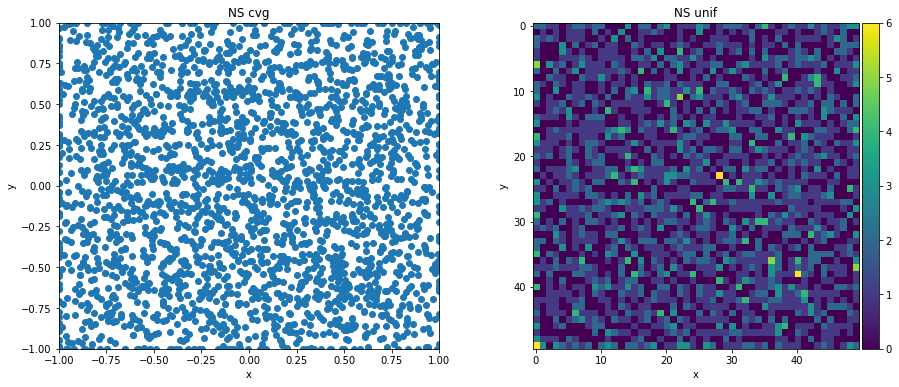

In [7]:
fig, axes = plt.subplots(len(exp_types), 2, figsize=(15, len(exp_types)*6))

for exp_idx, exp in enumerate(exp_types):
    points = gt_points[exp][best_run[exp]]
    hist, grid = utils.get_grid(points, grid_parameters)
    
    if len(exp_types) == 1:
        axes = [axes]

    axes[exp_idx][0].scatter(points[:, 0], points[:, 1])
    axes[exp_idx][0].set_title('{} cvg'.format(exp))
    axes[exp_idx][1].clear()
    divider = make_axes_locatable(axes[exp_idx][1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = axes[exp_idx][1].imshow(hist)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    axes[exp_idx][1].set_title('{} unif'.format(exp))
    
    axes[exp_idx][0].set_xlabel('x')
    axes[exp_idx][0].set_ylabel('y')
    axes[exp_idx][0].set_xlim(grid_parameters['min_coord'][0], grid_parameters['max_coord'][0])
    axes[exp_idx][0].set_ylim(grid_parameters['min_coord'][1], grid_parameters['max_coord'][1])
    axes[exp_idx][1].set_xlabel('x')
    axes[exp_idx][1].set_ylabel('y')

plt.show()
    